In [1]:
import numpy as np
import networkx as nx
from scipy.special import softmax
import matplotlib.pyplot as plt
from numba import jitclass
from numba import int32, float32, boolean

In [2]:
class DeepWalk(object):
    def __init__(self, walk_length=5, window_size=2, n_walks=1, n_dim=2, learning_rate=0.01, decay_rate=1, verbose=False):
        self.walk_length = walk_length
        self.window_size = window_size
        self.n_walks = n_walks
        self.n_dim = n_dim
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.verbose = verbose
        
    def fit(self, G):
        
        if not isinstance(G, nx.classes.graph.Graph):
            raise TypeError('G must be networkx Graph object.')
        
        A = nx.convert_matrix.to_numpy_array(G)
        self.__n = A.shape[0]
        
        # make sure A is symmetric
        if (A.sum(axis=1) != A.sum(axis=0)).any():
            raise ValueError('Graph must be undirected.')
        
        # calculate transition matrix P
        D = np.zeros(A.shape)
        d_diag = A.sum(axis=1)
        np.fill_diagonal(D, d_diag)
        P = np.linalg.inv(D) @ A
        
        # Initialized Random Weights
        self.W = np.random.rand(A.shape[0], self.n_dim)
        self.C = np.random.rand(A.shape[0], self.n_dim)
        self.W_orig = self.W
        self.C_orig = self.C
        self.loss_ = np.zeros(self.n_walks)
        prev_loss = np.inf
        for N in range(self.n_walks):
            self.loss = 0
            self.lr = self.learning_rate/(1 + self.decay_rate*N)
            walk = self.__generate_random_walk(A, P)

            # make contexts
            samples = self.__generate_contexts(walk)
            
            for w_t, w_c in samples:
                # forward pass
                y_pred, h, u = self.__forward_pass(w_t)
                
                # Calculate Error
                EI = np.sum([np.subtract(y_pred, context) for context in w_c], axis=0)
                
                # Backpropagate
                self.__backpropagate(EI, h, w_t)
        
                # calculate loss
                self.loss += -np.sum([u[list(context).index(True)] for context in w_c]) + len(w_c)*np.log(np.sum(np.exp(u)))
            self.loss_[N] = self.loss
            if self.verbose:
                print(f'Walk: {N} Loss: {self.loss}')
            
        return self
    
    def __generate_random_walk(self, A, P):
        
        walk = np.zeros(self.walk_length)
        node = np.random.choice(A.shape[0])
        walk[0] = node

        for i in range(1, self.walk_length):
            probs = P[node]
            node = np.random.choice(A.shape[0], p=probs)
            walk[i] = node
            
        return walk
    
    def __to_onehot(self, word):
        
        onehot = np.zeros(self.__n, dtype=bool)
        onehot[int(word)] = True
    
        return onehot
            
    def __generate_contexts(self, walk):
        sample = []
        for i in range(self.walk_length):
            center_word = self.__to_onehot(walk[i])
            contexts = []
            for j in range(i-self.window_size, i+self.window_size+1):
                if (j >= 0) and (i != j) and (j < self.walk_length):
                    contexts.append(self.__to_onehot(walk[j]))
            sample.append([center_word, contexts])
        return sample
        
    def __forward_pass(self, w):
        
        h = self.W.T @ w
        u = self.C @ h
        y_c = softmax(u)
        
        return y_c, h, u
    
    
    def __backpropagate(self, error, h, x):
        
        dL_dC = np.outer(error, h) # shape (n,d)
        dL_dW = np.outer(x, np.dot(self.C.T, error))
       
        self.W = self.W - self.lr*dL_dW
        self.C = self.C - self.lr*dL_dC
        
        
        

In [3]:
# Random Graph
G = nx.random_partition_graph(sizes=[20,20],
                              p_in=0.8,
                              p_out=0.05,
                              seed=1138)



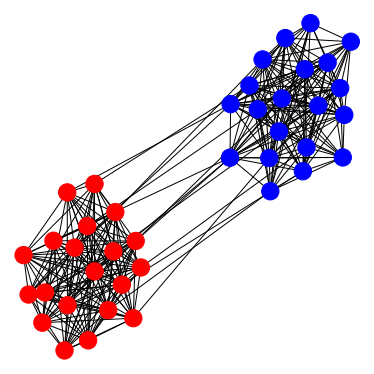

In [4]:
colors = ['blue', 'red']
color_map = []
for c, partition in enumerate(G.graph['partition']):
    for node in partition:
        color_map.append(colors[c])
plt.figure(figsize=(5,5))
nx.draw(G, node_color=color_map, pos=nx.spring_layout(G))
plt.show()

In [5]:
dw = DeepWalk(walk_length=100, window_size=5, n_walks=1000, n_dim=2, learning_rate=0.01, decay_rate=0.001, verbose=False).fit(G)

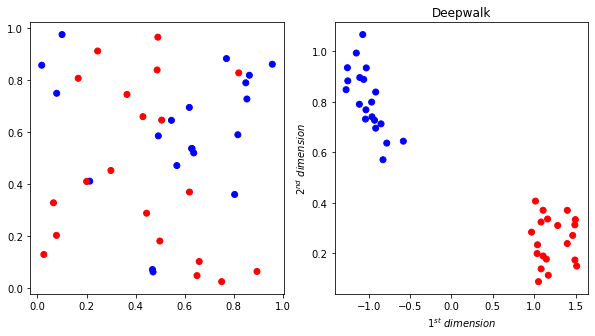

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(dw.W_orig[:, 0], dw.W_orig[:, 1], c=color_map)
ax[1].scatter(dw.W[:, 0], dw.W[:, 1], c=color_map)
plt.xlabel('$1^{st}$ $dimension$')
plt.ylabel('$2^{nd}$ $dimension$')
plt.title('Deepwalk')
plt.show()

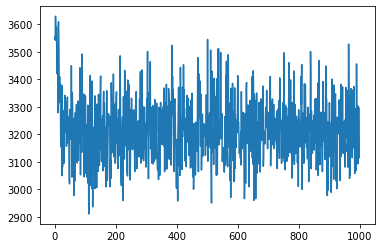

In [9]:
plt.plot(range(len(dw.loss_)), dw.loss_)
plt.show()

In [29]:
# Random Graph
G = nx.stochastic_block_model(sizes=[3,37],
                              p = [[1, 0.8],
                                   [0.8, 0.25]],
                              seed=1138)

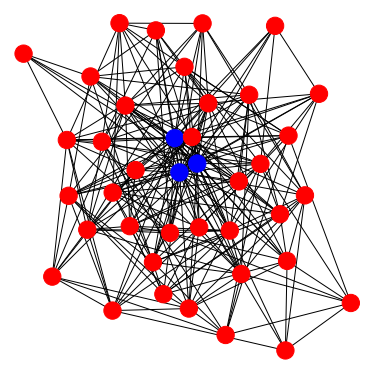

In [31]:
colors = ['blue', 'red']
color_map = []
for c, partition in enumerate(G.graph['partition']):
    for node in partition:
        color_map.append(colors[c])
plt.figure(figsize=(5,5))
nx.draw(G, node_color=color_map, pos=nx.spring_layout(G))
plt.show()

In [34]:
dw = DeepWalk(walk_length=100, window_size=5, n_walks=2000, n_dim=3, learning_rate=0.001, decay_rate=0.001, verbose=False).fit(G)

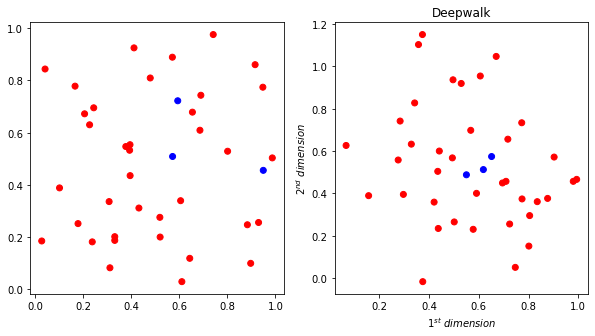

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(dw.W_orig[:, 0], dw.W_orig[:, 1], c=color_map)
ax[1].scatter(dw.W[:, 0], dw.W[:, 1], c=color_map)
plt.xlabel('$1^{st}$ $dimension$')
plt.ylabel('$2^{nd}$ $dimension$')
plt.title('Deepwalk')
plt.show()